In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import json
import pymongo
from src.benchmark.utils import get_system_info, generate_rand_movie_doc

print("PyMongo Version:", pymongo.__version__)
print("System Info:\n", json.dumps(get_system_info(), indent=3))

PyMongo Version: 4.13.1
System Info:
 {
   "python_version": "3.12.1",
   "system": {
      "os": "Darwin",
      "release": "24.5.0",
      "machine": "x86_64",
      "processor": "i386"
   },
   "cpu": {
      "physical_cores": 8,
      "total_cores": 8,
      "frequency_mhz": 2400
   },
   "memory": {
      "total_ram_gb": 16.0,
      "available_ram_gb": 0.82
   }
}


# Data Load

In [48]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")

In [49]:
try:
    client.admin.command('ping')
    print("Successfully connected to MongoDB")
except Exception as e:
    print(f"Connection failed: {e}")

Successfully connected to MongoDB


In [50]:
print("Databases:", client.list_database_names())

Databases: ['admin', 'bdnr_MovieLens_ml_25m', 'benchmark_db', 'config', 'local']


In [51]:
from pprint import pprint

def print_collection_info(db_name, collection_name):
    print(f"\n{db_name}.{collection_name}")
    collection = client[db_name][collection_name]
    for doc in collection.find().limit(1):  # First documents
        pprint(doc)

# Admin DB collections
print_collection_info('admin', 'system.version')
# Local DB collections
print_collection_info('local', 'startup_log')


admin.system.version
{'_id': 'featureCompatibilityVersion', 'version': '7.0'}

local.startup_log
{'_id': 'UY000MC64N6TY7K-1747265527787',
 'buildinfo': {'allocator': 'system',
               'bits': 64,
               'buildEnvironment': {'cc': '/Applications/Xcode13.2.1.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/clang: '
                                          'Apple clang version 13.0.0 '
                                          '(clang-1300.0.29.30)',
                                    'ccflags': '-Wno-error=unknown-warning-option '
                                               '-isysroot '
                                               '/Applications/Xcode13.2.1.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX12.1.sdk '
                                               '-mmacosx-version-min=11.0 '
                                               '--target=darwin20.0.0 -arch '
                                               'arm64 -Werro

### Create new collections

In [52]:
# Create database and collections
db = client["bdnr_MovieLens_ml_25m"]

movies_col = db["movies"]
users_col = db["users"]

In [53]:
# client.drop_database("bdnr_MovieLens_ml_25m_test")

### Load collections

In [54]:
import pandas as pd

# Read CSV files
base_path = "/Users/efaliveni//Downloads/ml-25m"

ratings = pd.read_csv(f"{base_path}/ratings.csv")
movies = pd.read_csv(f"{base_path}/movies.csv")
tags = pd.read_csv(f"{base_path}/tags.csv")
genome_tags = pd.read_csv(f"{base_path}/genome-tags.csv")
genome_scores = pd.read_csv(f"{base_path}/genome-scores.csv")

In [55]:
# Filter Data
SAMPLE_SIZE = 500

selected_users = ratings['userId'].unique()[:SAMPLE_SIZE]
filtered_ratings = ratings[ratings['userId'].isin(selected_users)]
filtered_movie_ids = filtered_ratings['movieId'].unique()
filtered_movies = movies[movies['movieId'].isin(filtered_movie_ids)]
filtered_tags = tags[tags['movieId'].isin(filtered_movie_ids)]
filtered_scores = genome_scores[genome_scores['movieId'].isin(filtered_movie_ids)]

In [56]:
from collections import defaultdict
# Create a dictionary of genome tags for quick lookup
genome_tags_dict = {row['tagId']: row['tag'] for _, row in genome_tags.iterrows()}

# Build dictionaries to accumulate data
ratings_by_movie = defaultdict(list)
scores_by_movie = defaultdict(list)

ratings_by_user = defaultdict(list)
tags_by_user = defaultdict(list)

In [57]:
# Process ratings and tags to build both movie and user views
RELEVANCE_THRESHOLD = 0.8

# Ratings
for _, r in filtered_ratings.iterrows():
    movie_id = int(r.movieId)
    user_id = int(r.userId)
    
    # Add to movie's ratings
    ratings_by_movie[movie_id].append({
        "userId": user_id,
        "rating": float(r.rating),
        "timestamp": int(r.timestamp)
    })
    
    # Add to user's ratings
    ratings_by_user[user_id].append({
        "movieId": movie_id,
        "rating": float(r.rating),
        "timestamp": int(r.timestamp)
    })
    
# Tags (only for users), genome tag is the cleaned infered tag
for _, t in filtered_tags.dropna(subset=["tag"]).iterrows():
    movie_id = int(t.movieId)
    user_id = int(t.userId)
    
    tags_by_user[user_id].append({
        "movieId": movie_id,
        "tag": t.tag,
        "timestamp": int(t.timestamp)
    })
    
# Genome scores (only for movies), with 0.8 threshold
for _, s in filtered_scores[filtered_scores.relevance > RELEVANCE_THRESHOLD].iterrows():
    movie_id = int(s.movieId)
    tag_id = int(s.tagId)
    
    scores_by_movie[movie_id].append({
        "tagId": tag_id,
        "tag": genome_tags_dict.get(tag_id, ""),
        "relevance": float(s.relevance)
    })

In [58]:
import re

# Build movie documents
movie_docs = []
for _, m in filtered_movies.iterrows():
    movie_id = int(m.movieId)
   
    # Extract year from title
    title = m.title
    year_match = re.search(r"\((\d{4})\)$", title)
    year = int(year_match.group(1)) if year_match else None
    
    # Calculate statistics
    movie_ratings = ratings_by_movie.get(movie_id, [])
    rating_count = len(movie_ratings)
    if rating_count > 0:
        avg_rating = sum(r['rating'] for r in movie_ratings) / rating_count
        # Calculate rating distribution (count of each star rating)
        rating_dist = {"0.5":0, "1.0":0, "1.5":0, "2.0":0, "2.5":0, 
                      "3.0":0, "3.5":0, "4.0":0, "4.5":0, "5.0":0}
        for r in movie_ratings:
            rating_key = f"{r['rating']}"
            rating_dist[rating_key] += 1 
    else:
        avg_rating = 0.0
        rating_dist = {}
        
    movie_docs.append({
        "movieId": movie_id,
        "title": title,
        "year": year,
        "genres": m.genres.split("|") if pd.notna(m.genres) else [],
        "ratings": ratings_by_movie.get(movie_id, []),
        "tagGenome": scores_by_movie.get(movie_id, []),
        "stats": {
            "ratingCount": rating_count,
            "avgRating": round(avg_rating, 2),
            "ratingDistribution": rating_dist
        },

    })

In [59]:
# Build user documents with rating interaction history
user_docs = []
for user_id in selected_users:
    user_id = int(user_id)
    
    # Get all user activity
    user_ratings = ratings_by_user.get(user_id, [])
    user_tags = tags_by_user.get(user_id, [])
    
    # Calculate basic stats
    rating_count = len(user_ratings)
    avg_rating = sum(r['rating'] for r in user_ratings) / rating_count if rating_count > 0 else 0
    tag_count = len(user_tags)
    
    # Create rating interaction history
    rating_interactions = [
        {
            "movieId": rating['movieId'],
            "rating": rating['rating'],
            "timestamp": rating['timestamp']
        }
        for rating in user_ratings
    ]
    
    # Add tags to history with type designation
    # tag_interactions = [
    #     {
    #         "movieId": tag['movieId'],
    #         "tag": tag['tag'],
    #         "timestamp": tag['timestamp']
    #     }
    #     for tag in user_tags
    # ]
    
    # Sort interactions by timestamp (oldest first)
    rating_interactions.sort(key=lambda x: x['timestamp'])
    # tag_interactions.sort(key=lambda x: x['timestamp'])
    
    user_docs.append({
        "userId": user_id,
        "stats": {
            "ratingCount": rating_count,
            "avgRating": round(avg_rating, 2),
        },
        "ratingHistory": rating_interactions,
        # "tagHistory": tag_interactions
    })

In [60]:
movies_col.delete_many({})
users_col.delete_many({})

DeleteResult({'n': 859, 'ok': 1.0}, acknowledged=True)

In [61]:
import time

# Insert data
start = time.time()
movies_col.insert_many(movie_docs)
users_col.insert_many(user_docs)
end = time.time()

print(f"Total processing and loading time: {end - start:.2f} seconds")
print(f"Movies loaded: {len(movie_docs)}")
print(f"Users loaded: {len(user_docs)}")

Total processing and loading time: 0.33 seconds
Movies loaded: 7141
Users loaded: 500


### Sample Movie

In [62]:
sample_movie = movies_col.find_one({}, {'_id': 0})  # Exclude MongoDB _id
print(json.dumps(sample_movie, indent=2, default=str))

{
  "movieId": 1,
  "title": "Toy Story (1995)",
  "year": 1995,
  "genres": [
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Fantasy"
  ],
  "ratings": [
    {
      "userId": 2,
      "rating": 3.5,
      "timestamp": 1141415820
    },
    {
      "userId": 3,
      "rating": 4.0,
      "timestamp": 1439472215
    },
    {
      "userId": 4,
      "rating": 3.0,
      "timestamp": 1573944252
    },
    {
      "userId": 5,
      "rating": 4.0,
      "timestamp": 858625949
    },
    {
      "userId": 8,
      "rating": 4.0,
      "timestamp": 890492517
    },
    {
      "userId": 10,
      "rating": 3.5,
      "timestamp": 1227571347
    },
    {
      "userId": 12,
      "rating": 4.0,
      "timestamp": 1167582601
    },
    {
      "userId": 13,
      "rating": 4.0,
      "timestamp": 1265223970
    },
    {
      "userId": 18,
      "rating": 3.0,
      "timestamp": 1108273483
    },
    {
      "userId": 26,
      "rating": 3.0,
      "timestamp": 12805158

### Sample User

In [63]:
sample_user = users_col.find_one({}, {'_id': 0}) 
print(json.dumps(sample_user, indent=2, default=str))

{
  "userId": 1,
  "stats": {
    "ratingCount": 70,
    "avgRating": 3.81
  },
  "ratingHistory": [
    {
      "movieId": 5952,
      "rating": 4.0,
      "timestamp": 1147868053
    },
    {
      "movieId": 2012,
      "rating": 2.5,
      "timestamp": 1147868068
    },
    {
      "movieId": 2011,
      "rating": 2.5,
      "timestamp": 1147868079
    },
    {
      "movieId": 1653,
      "rating": 4.0,
      "timestamp": 1147868097
    },
    {
      "movieId": 1250,
      "rating": 4.0,
      "timestamp": 1147868414
    },
    {
      "movieId": 6539,
      "rating": 3.5,
      "timestamp": 1147868461
    },
    {
      "movieId": 6377,
      "rating": 4.0,
      "timestamp": 1147868469
    },
    {
      "movieId": 3448,
      "rating": 4.0,
      "timestamp": 1147868480
    },
    {
      "movieId": 1088,
      "rating": 4.0,
      "timestamp": 1147868495
    },
    {
      "movieId": 899,
      "rating": 3.5,
      "timestamp": 1147868510
    },
    {
      "movieId": 4308,
 

# Single-Threaded Benchmark
Simulate User Load, real time latency stress

In [64]:
# explain()
movies_col.find({"movieId": 1}).limit(1).explain()

{'explainVersion': '1',
 'queryPlanner': {'namespace': 'bdnr_MovieLens_ml_25m.movies',
  'indexFilterSet': False,
  'parsedQuery': {'movieId': {'$eq': 1}},
  'queryHash': '83236E15',
  'planCacheKey': 'C6A07768',
  'maxIndexedOrSolutionsReached': False,
  'maxIndexedAndSolutionsReached': False,
  'maxScansToExplodeReached': False,
  'winningPlan': {'stage': 'LIMIT',
   'limitAmount': 1,
   'inputStage': {'stage': 'FETCH',
    'inputStage': {'stage': 'IXSCAN',
     'keyPattern': {'movieId': 1},
     'indexName': 'movieId_1',
     'isMultiKey': False,
     'multiKeyPaths': {'movieId': []},
     'isUnique': False,
     'isSparse': False,
     'isPartial': False,
     'indexVersion': 2,
     'direction': 'forward',
     'indexBounds': {'movieId': ['[1, 1]']}}}},
  'rejectedPlans': []},
 'executionStats': {'executionSuccess': True,
  'nReturned': 1,
  'executionTimeMillis': 0,
  'totalKeysExamined': 1,
  'totalDocsExamined': 1,
  'executionStages': {'stage': 'LIMIT',
   'nReturned': 1,
   '

### Benchmark:

- Prevent memory caching.
- Use indexed queries that simulate realistic application behavior.
- Measure read & writes.
- Randomized access patterns, multi-threading, or batch loads. (Out of scope)


In [65]:
import random
import time
from pymongo import MongoClient
from src.benchmark.mongo_listener import BenchListener
from src.benchmark.mongo_benchmark import run_benchmark
from src.benchmark.utils import timed_op

listener = BenchListener(watched_commands={"find", "insert", "aggregate"})
client = MongoClient("mongodb://localhost:27017", event_listeners=[listener])
db = client["bdnr_MovieLens_ml_25m"]
movies_col = db["movies"]
users_col = db["users"]

In [66]:
# Create indexes: B-Tree-based data structure
# Each node can point to multiple children, making it fast for lookup and traversal.
# Leaf nodes contain pointers (references) to actual documents in the collection.

movies_col.create_index("movieId")
movies_col.create_index("genres")
users_col.create_index("userId")

'userId_1'

In [67]:
# ----------- Read Operations -------------
@timed_op
def find_by_movie_id():
    return list(movies_col.find({"movieId": random.randint(1, 1000)}).limit(1))

@timed_op
def top_rated_movie():
    return list(movies_col.find({"stats.avgRating": {"$gt": 4.5}}).limit(10))

@timed_op
def search_by_genre():
    return list(movies_col.find({"genres": "Comedy"}).limit(10))

@timed_op
def search_by_title_regex():
    return list(movies_col.find({"title": {"$regex": "story", "$options": "i"}}).limit(5))

@timed_op
def user_movie_join():
    user_ids = [random.randint(1, 1000) for _ in range(3)]
    return list(users_col.aggregate([
        {"$match": {"userId": {"$in": user_ids}}},
        {"$lookup": {
            "from": "movies",
            "localField": "ratings.movieId",
            "foreignField": "movieId",
            "as": "movieDetails"
        }},
        {"$limit": 3}
    ]))

In [68]:
queries = [
    ("find_by_id", find_by_movie_id),
    ("top_rated", top_rated_movie),
    ("genre_search", search_by_genre),
    ("title_search_regex", search_by_title_regex),
    ("user_ratings_with_movie_details", user_movie_join),
]

for query_id, query_func in queries:
    result = run_benchmark(query_id, query_func, listener, duration=20)
    print(f"{query_id} result summary:", result.summary)

find_by_id result summary: {'query': 'find_by_id', 'duration': 20, 'iterations': 352, 'successes': 352, 'errors': 0, 'wall_avg_ms': 2.901906011363636, 'wall_p95_ms': 5.42572895, 'wall_p99_ms': 11.90786474, 'driver_avg_ms': 2.224747159090909, 'driver_p95_ms': 4.70255, 'driver_p99_ms': 9.92174, 'cpu_avg_pct': 11.641761363636364, 'cpu_p95_pct': 42.655, 'cpu_p99_pct': 51.523, 'sys_mem_avg_pct': 95.04801136363636, 'sys_mem_p95_pct': 95.1, 'sys_mem_p99_pct': 95.1, 'rss_avg_mb': 134.0107421875, 'rss_p95_mb': 153.36484375, 'rss_p99_mb': 153.56984375, 'major_faults_per_sec': 0.15, 'throughput_qps': 17.6}
top_rated result summary: {'query': 'top_rated', 'duration': 20, 'iterations': 350, 'successes': 350, 'errors': 0, 'wall_avg_ms': 3.244299402857143, 'wall_p95_ms': 5.21560595, 'wall_p99_ms': 11.699803580000001, 'driver_avg_ms': 2.6073714285714287, 'driver_p95_ms': 4.134950000000001, 'driver_p99_ms': 11.06785, 'cpu_avg_pct': 8.795428571428571, 'cpu_p95_pct': 39.815, 'cpu_p99_pct': 61.76399999999

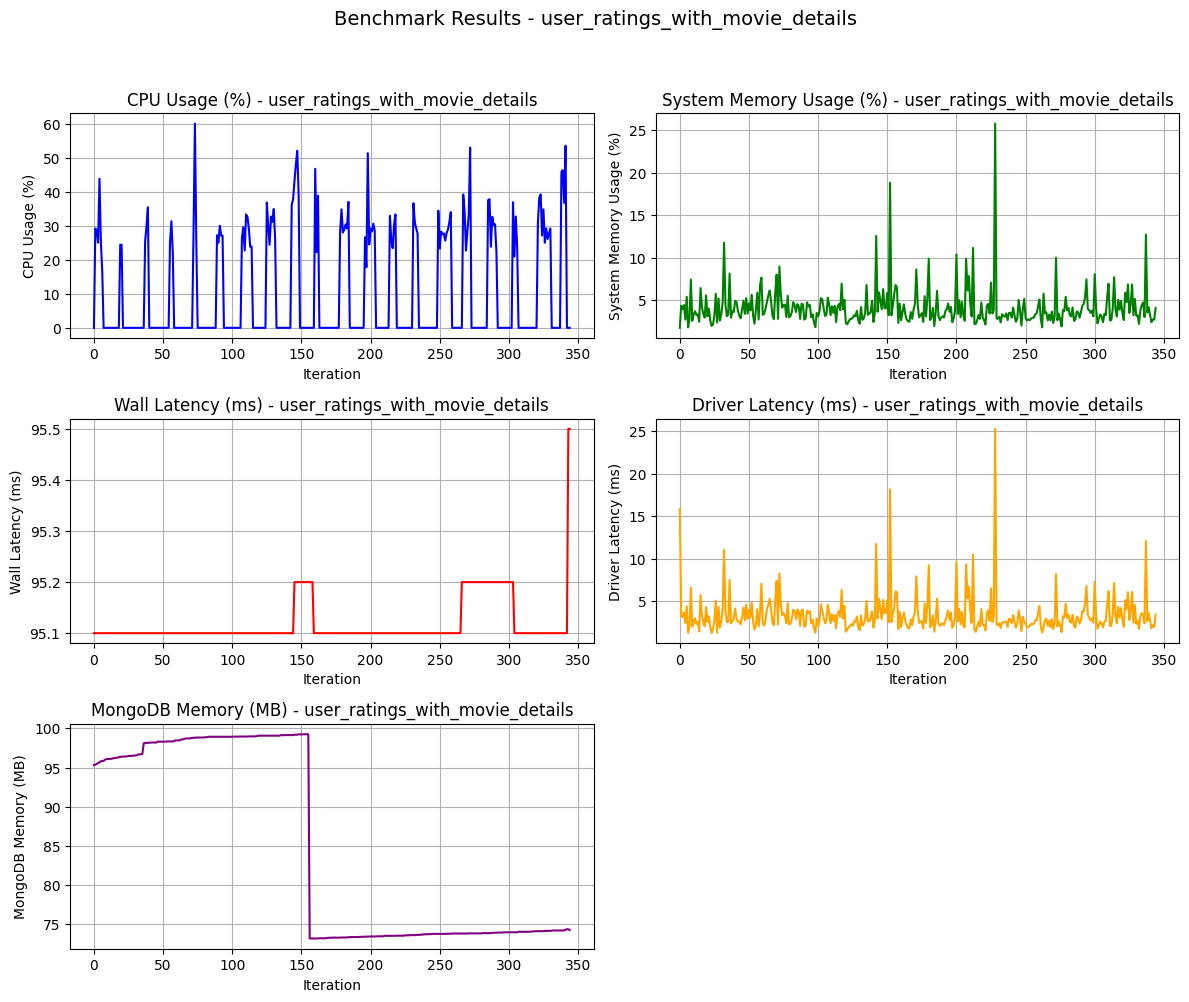

In [69]:
from src.benchmark.utils import plot_benchmark_results

plot_benchmark_results(
    query_id,
    result.series["sys_cpu_pct"],
    result.series["sys_mem_pct"],
    result.series["wall_ms"],    
    result.series["driver_ms"],
    mongo_mem=result.series["mongo_rss_mb"]
)

In [70]:
from datetime import datetime

# ----------- Write Operations -------------
@timed_op
def insert_single_movie():
    doc = generate_rand_movie_doc(random.randint(1, 10_000))
    return movies_col.insert_one(doc)

@timed_op
def insert_multiple_movies():
    docs = [generate_rand_movie_doc(random.randint(1, 10_000)) for _ in range(5)]
    return movies_col.insert_many(docs)

@timed_op
def insert_user_with_ratings():
    user_id = random.randint(1, 5_000)
    ratings = [{"movieId": random.randint(1, 1000), "rating": random.uniform(1.0, 5.0), "timestamp": datetime.now()} for _ in range(5)]
    doc = {
        "userId": user_id,
        "name": f"User_{user_id}",
        "stats": {"ratingCount": len(ratings)},
        "ratings": ratings
    }
    return users_col.insert_one(doc)

In [71]:
write_queries = [
    ("insert_single_movie", insert_single_movie),
    ("insert_multiple_movies", insert_multiple_movies),
    ("insert_user_with_ratings", insert_user_with_ratings),
]

for query_id, query_func in write_queries:
    result = run_benchmark(query_id, query_func, listener, duration=20)
    print(f"{query_id} result summary:", result.summary)

insert_single_movie result summary: {'query': 'insert_single_movie', 'duration': 20, 'iterations': 348, 'successes': 348, 'errors': 0, 'wall_avg_ms': 3.8847947787356323, 'wall_p95_ms': 7.85031905, 'wall_p99_ms': 16.69008817, 'driver_avg_ms': 2.2591034482758623, 'driver_p95_ms': 6.55565, 'driver_p99_ms': 14.363690000000002, 'cpu_avg_pct': 10.888505747126437, 'cpu_p95_pct': 41.885000000000005, 'cpu_p99_pct': 75.574, 'sys_mem_avg_pct': 95.01206896551724, 'sys_mem_p95_pct': 95.3, 'sys_mem_p99_pct': 95.4, 'rss_avg_mb': 58.174973060344826, 'rss_p95_mb': 63.22734375, 'rss_p99_mb': 72.8175, 'major_faults_per_sec': 0.0, 'throughput_qps': 17.4}
insert_multiple_movies result summary: {'query': 'insert_multiple_movies', 'duration': 20, 'iterations': 324, 'successes': 324, 'errors': 0, 'wall_avg_ms': 8.008702259259259, 'wall_p95_ms': 11.709978999999999, 'wall_p99_ms': 16.8940935, 'driver_avg_ms': 2.7790216049382717, 'driver_p95_ms': 4.691999999999999, 'driver_p99_ms': 11.649750000000001, 'cpu_avg_p

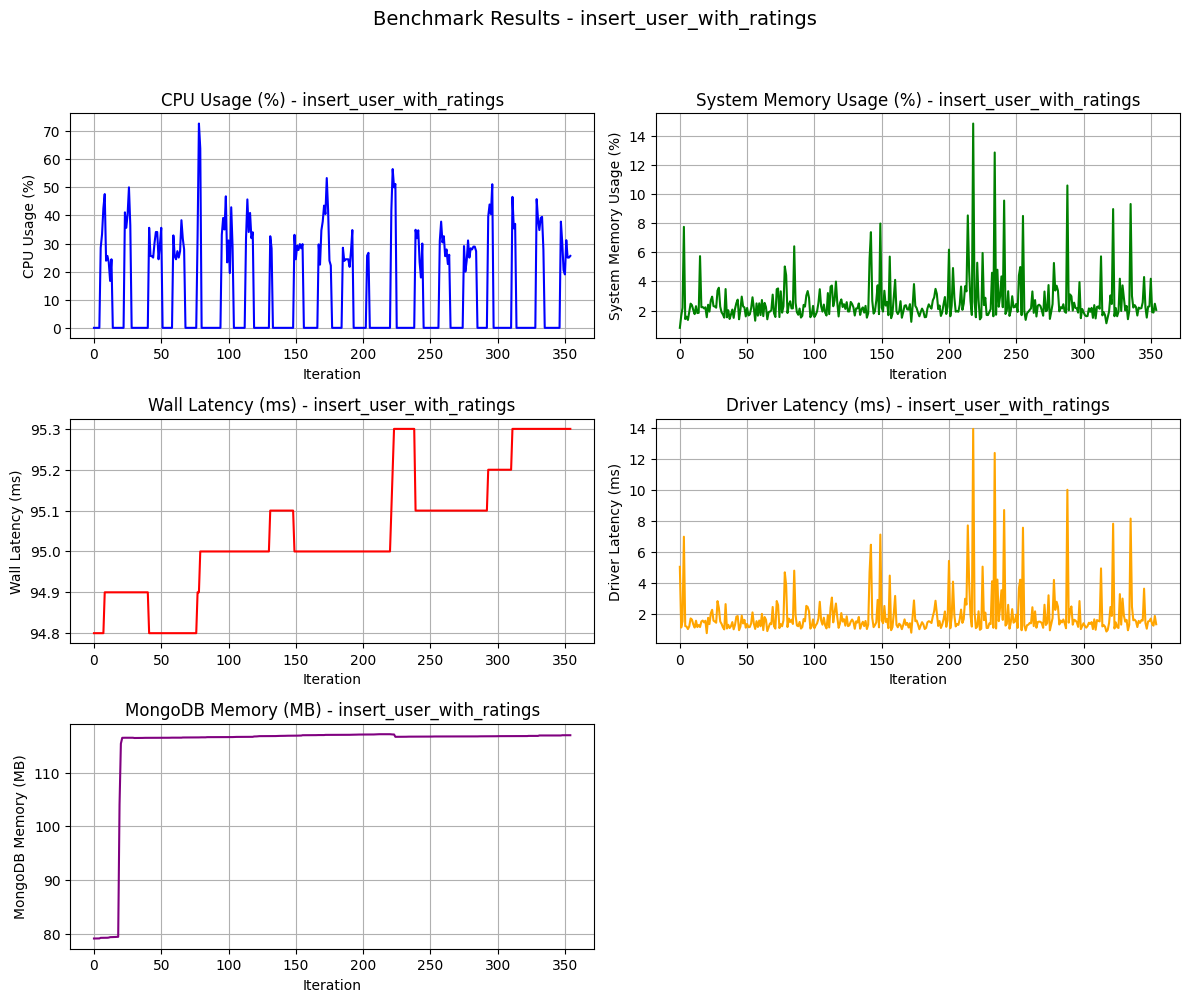

In [72]:
from src.benchmark.utils import plot_benchmark_results

plot_benchmark_results(
    query_id,
    result.series["sys_cpu_pct"],
    result.series["sys_mem_pct"],
    result.series["wall_ms"],    
    result.series["driver_ms"],
    mongo_mem=result.series["mongo_rss_mb"]
)

In [73]:
import numpy as np

USER_SAMPLE_SIZE = 300
SAMPLE_POOL = list(np.random.choice(selected_users, size=USER_SAMPLE_SIZE, replace=False))

In [77]:
# ----------- Update Operations -------------
from datetime import datetime
import time

@timed_op
def update_user_rating_timestamps():
    user_id = int(SAMPLE_POOL.pop())

    # Fetch the user's ratings
    user_doc = users_col.find_one({"userId": user_id}, {"ratings": 1})
    if not user_doc or "ratings" not in user_doc:
        return None

    updated_ratings = []
    for rating in user_doc["ratings"]:
        ts = rating.get("timestamp")
        if isinstance(ts, (int, float)):
            rating["timestamp"] = datetime.fromtimestamp(ts)
        updated_ratings.append(rating)

    # Write the updated ratings back
    result = users_col.update_one(
        {"userId": user_id},
        {"$set": {"ratings": updated_ratings}}
    )

    return result

In [80]:
# @timed_op
# def update_user_rating_timestamps():
#     user_id = int(SAMPLE_POOL.pop())
# 
#     pipeline = [
#         {"$match": {"userId": user_id}},
#         {
#             "$set": {
#                 "ratings": {
#                     "$map": {
#                         "input": "$ratings",
#                         "as": "r",
#                         "in": {
#                             "$mergeObjects": [
#                                 "$$r",
#                                 {
#                                     "timestamp": {
#                                         "$cond": [
#                                             { "$isNumber": "$$r.timestamp" },
#                                             { "$toDate": { "$multiply": ["$$r.timestamp", 1000] } },
#                                             "$$r.timestamp"
#                                         ]
#                                     }
#                                 }
#                             ]
#                         }
#                     }
#                 }
#             }
#         },
#         {
#             "$merge": {
#                 "into": "users",
#                 "whenMatched": "merge",
#                 "whenNotMatched": "discard"
#             }
#         }
#     ]
# 
#     return users_col.aggregate(pipeline)

In [81]:
update_queries = [
    ("update_user_rating_timestamps", update_user_rating_timestamps)
]

for query_id, query_func in update_queries:
    result = run_benchmark(query_id, query_func, listener, duration=5)
    print(f"{query_id} result summary:", result.summary)

update_user_rating_timestamps result summary: {'query': 'update_user_rating_timestamps', 'duration': 2, 'iterations': 34, 'successes': 34, 'errors': 0, 'wall_avg_ms': 4.036452235294117, 'wall_p95_ms': 20.064854, 'wall_p99_ms': 31.8576364, 'driver_avg_ms': 3.807235294117647, 'driver_p95_ms': 19.6855, 'driver_p99_ms': 31.325100000000003, 'cpu_avg_pct': 12.344117647058823, 'cpu_p95_pct': 64.15, 'cpu_p99_pct': 89.63, 'sys_mem_avg_pct': 94.8, 'sys_mem_p95_pct': 94.8, 'sys_mem_p99_pct': 94.8, 'rss_avg_mb': 50.400275735294116, 'rss_p95_mb': 51.81640625, 'rss_p99_mb': 51.92578125, 'major_faults_per_sec': 5.0, 'throughput_qps': 17.0}


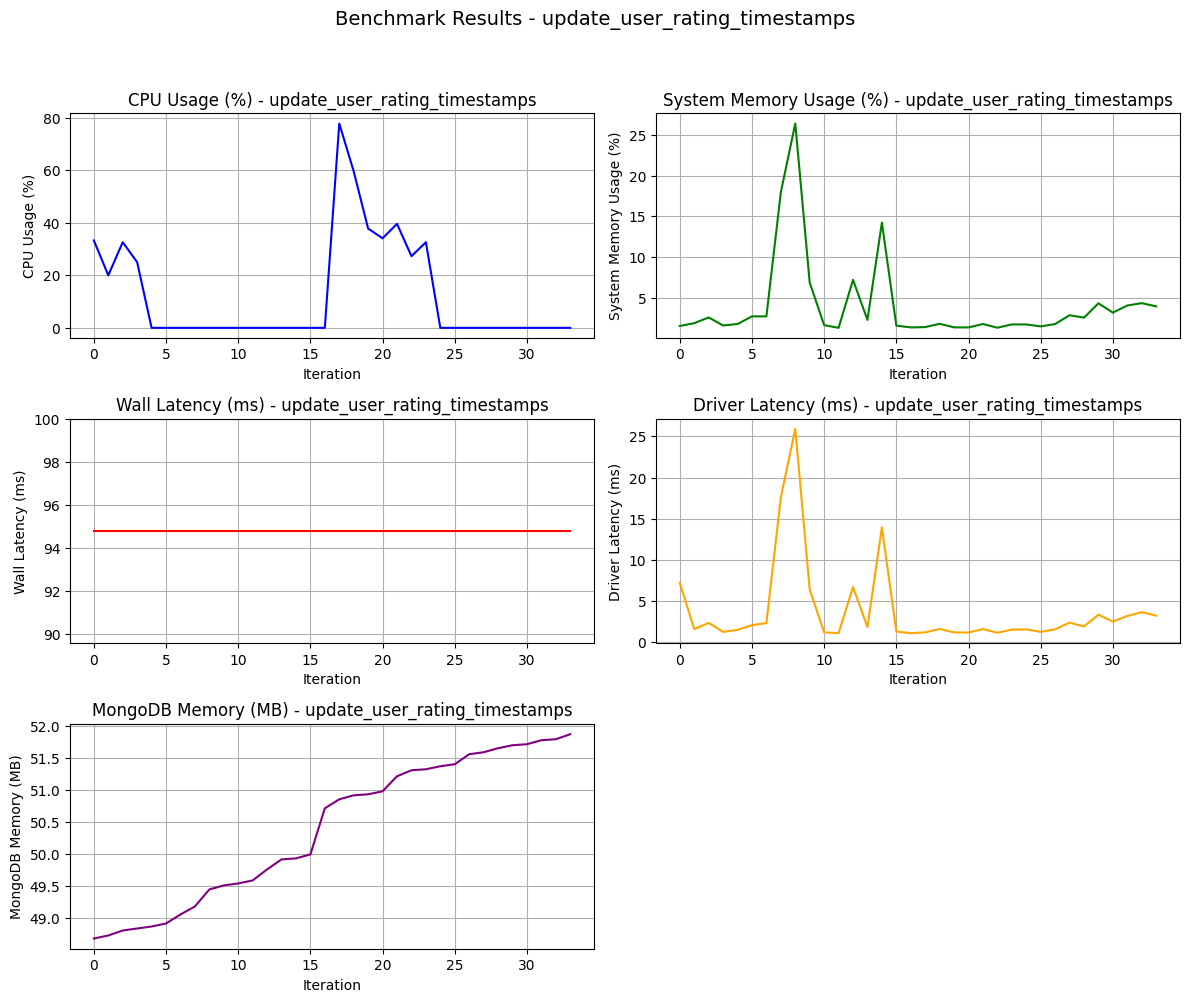

In [82]:
from src.benchmark.utils import plot_benchmark_results

plot_benchmark_results(
    query_id,
    result.series["sys_cpu_pct"],
    result.series["sys_mem_pct"],
    result.series["wall_ms"],    
    result.series["driver_ms"],
    mongo_mem=result.series["mongo_rss_mb"]
)

# MongoDB's internal Profiler

Diagnosing MongoDB query behavior, useful for optimizing queries and indexes  

In [ ]:
# Deep dive in server-side execution
def profiled_benchmark():
    db.command('profile', 0)  # Disable first
    db.system.profile.drop()  # Clear old data
    db.command('profile', 2, slowms=0)  # Profile all operations
    
    # Run benchmark
    for _ in range(1):
        movies_col = db["movies"]
        _ = movies_col.find_one({}, {'_id': 0}) 
    
    # Collect profile data
    time.sleep(1)  # Ensure all ops are captured
    profile_data = list(db.system.profile.find({
        "ns": {"$ne": f"{movies_col}.system.profile"},
        "op": {"$in": ["query", "update", "insert", "delete", "command"]},
    }).sort("ts", -1))
    
    analyzed_data = {
        "query_count": len(profile_data),
        "avg_duration": (sum(op.get("millis", 0) for op in profile_data) / 
                       len(profile_data) if profile_data else 0),
        "operations": []
    }
#   print(profile_data)
  
    for op in profile_data[:100]:  # Limit to first 100 ops
        analyzed_data["operations"].append({
            "operation": op.get("op"),
            "namespace": op.get("ns"),
            "duration_ms": op.get("millis", 0),
            "docs_examined": op.get("docsExamined", 0),
            "keys_examined": op.get("keysExamined", 0),
            "nreturned": op.get("nreturned", 0),
            "plan": op.get("planSummary", "N/A")
        })
        
    return analyzed_data

In [ ]:
profiled_benchmark()

# Global server-wide metrics

Server Status Global Info, useful for health dashboards

In [ ]:
# serverStatus
def extract_mongodb_benchmark_metrics(server_status):
    uptime_sec = server_status.get('uptime', 1)
    # MongoDB uses the WiredTiger storage engine (default since v3.2)
    wiredtiger = server_status.get('wiredTiger', {})
    opcounters = server_status.get('opcounters', {})

    
    # Query Efficiency
    query_executor = server_status.get('queryExecutor', {})
    scanned_objects = query_executor.get('scannedObjects', 1)
    index_usage_ratio = (
        (scanned_objects - query_executor.get('scanned', 0)) / 
        max(1, scanned_objects)
    ) * 100  # Percentage of queries using indexes

    # Throughput & Latency
    metrics = {
        'throughput': {
            'reads_sec': opcounters.get('query', 0) / uptime_sec,
            'writes_sec': (
                opcounters.get('insert', 0) + 
                opcounters.get('update', 0) + 
                opcounters.get('delete', 0)
            ) / uptime_sec,
        },
        'latency_ms': {
            'read_avg': server_status.get('opLatencies', {}).get('reads', {}).get('latency', 0) / 1000,
            'write_avg': server_status.get('opLatencies', {}).get('writes', {}).get('latency', 0) / 1000,
            'disk_read_avg': wiredtiger.get('perf', {}).get('file_system_read_latency', 0),
        },
        'index_efficiency': {
            'index_usage_percent': index_usage_ratio,
            'cache_hit_ratio': (
                wiredtiger.get('cache', {}).get('pages_requested', 1) - 
                wiredtiger.get('cache', {}).get('pages_read', 0)
            ) / max(1, wiredtiger.get('cache', {}).get('pages_requested', 1)) * 100,
        },
        'concurrency': {
            'active_connections': server_status.get('connections', {}).get('active', 0),
            'locked_transactions': server_status.get('globalLock', {}).get('currentQueue', {}).get('writers', 0),
        }
    }
    return metrics

server_status = client.admin.command('serverStatus')
pprint(extract_mongodb_benchmark_metrics(server_status))